<a href="https://colab.research.google.com/github/saguileran/MD-SCIP/blob/main/Drude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

This is a Jupyter notebook for running Molecular Dynamics (MD) simulations using OpenMM engine using the Drude polarizable force field. This notebook is an extension of the series of notebooks published in "***Making it rain: Cloud-based molecular simulations for everyone***" ([link here](https://doi.org/10.1021/acs.jcim.1c00998)) and we encourage you to read it before using this pipeline.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to run microsecond-long MD simulations in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for MD simulations!** It is just simple MD pipeline illustrating each step of a simulation protocol.

--- 
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/making-it-rain/issues

**Acknowledgments**
- We would like to thank the OpenMM team for developing an excellent and open source engine. 

- Making-it-rain by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- For related notebooks see: [Making-it-rain](https://github.com/pablo-arantes/making-it-rain)

---
---
# **Introduction**

In general, MD simulations rely on 1) a set of atomic coordinates of all atoms on a simulation box and 2) a set of force field parameters that describes the interaction energies between atoms. These force fields are commonly categorized into *non-polarizable* (also called *additive*) or *polarizable* models. Mainly, while in polarizable force fields all electrostatic interactions are sensitive to the changes in the surrounding chemical microenvironment, additive force fields are not.

In the Drude polarizable force field, electronic polarization is explicitly modeled via auxiliary particles that are attached to their parent atoms via harmonic springs. The so-called Drude particles are subjected to the electric field exerted by the surrounding atoms and displace from their parent atom as a polarization response. For more information on the Drude polarizable model, please refer to [Lemkul 2015](https://pubs.acs.org/doi/abs/10.1021/acs.chemrev.5b00505), [Lemkul 2020](https://www.sciencedirect.com/science/article/abs/pii/S1877117319302157?via%3Dihub) and their references.

Below, these drude particles are showed in green spheres attached to their respective parent atoms in an alanine dipeptide. Lone pairs are shown as yellow spheres. 

![drudemodel](https://drive.google.com/uc?id=1Gdgx_rKfrPvr718ZBodMdyguZm7xWafq)



---

Generally, a simulation using the Drude force field follows these steps:
 - 1) Build system using the CHARMM additive force field.
 - 2) Equilibrate the system while restraining the protein coordinates.
 - 3) Convert the equilibrated additive system to Drude FF (create Drude particles and lone pairs).
 - 4) Equilibrate the Drude system.
 - 5) Run the Drude production simulation.

Understanding this protocol is crucial for the steps covered in this notebook. Again: read the articles suggested above **BEFORE** attempting this tutorial.
---

For more information on how to create a solvated simulation box, please refer to CHARMM-GUI YouTube channel (https://www.youtube.com/channel/UCtHN7aNAjDet_JKWPxSioLQ)








---
# **1) Building your system in CHARMM-GUI**

In this notebook, we will simulate PDB 1UBQ, a ubiquitin molecule. To build our additive simulation box, we will use CHARMM-GUI (https://www.charmm-gui.org/) *solution builder* feature (Important: to use CHARMM-GUI, you must register for a free account). 

- Create your system using the *solution builder* tool. **IMPORTANT**: in this tutorial, we will not consider the crystallographic waters.
- Use a cubic box with an *edge distance* of 10 Angstroms.
- Include ions with a concentration of 0.15 M of KCl.
- Download your system choosing the OpenMM input format.

Alternatively, you can download the necessary input files from [here](https://github.com/pablo-arantes/making-it-rain/tree/main/OpenMM_Drude/additive).

---
We will need some files to start our additive equilibration. They are:
 - *step3_input.psf* containing the system topology.
 - *step3_input.pdb* containing the system coordinates
 - The restraint file (at *openmm/restraints/prot_pos.txt*) containing the atoms that will be restrained during equilibration.
 - The *toppar* folder containing force field parameter files.
 - The *toppar.str* file pointing to the force field files that we will use in our simulation.

Make a folder with these files and upload it to your Google Drive account.
**IMPORTANT:** you will need to edit your *toppar.str* file! This file indicates where the .rtf, .prm and .str files are located so OpenMM can read the force field parameters. Your *toppar.str* file should look something like the one below:

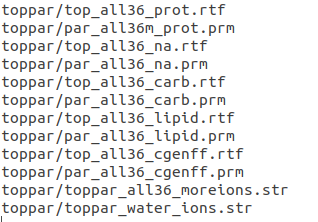

---
---
# **2) Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
!pip -q install py3Dmol
!pip install biopandas
!mamba install openmmforcefields -c conda-forge -y
!mamba install -c conda-forge ambertools -y
!pip install --upgrade MDAnalysis

#load dependencies
import sys
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [2]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" button to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jan 29 19:09:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
---
# **3) Loading additive input files**

At this point, we should have all libraries and dependencies installed and all necessary input files already at your Google Drive folder.

**IMPORTANT**: make sure the *toppar.str* file points to the correct pathway of all force field files. CHARMM-GUI assumes a certain directory structure that is not applicable here. Incorrect pathways will cause the job to crash. Correct the pathway and re-upload the files if necessary.

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them. Please, don't use spaces in the files and folders names, i.e., CHARMM_GUI, step3_input.pdb and so on.


In [4]:
#@title **Please, provide the necessary input files below:** 
PSF_filename = 'step3_input.psf' #@param {type:"string"}
PDB_filename = 'step3_input.pdb' #@param {type:"string"}
toppar_filename = 'toppar.str' #@param {type:"string"}
restraint_filename = 'prot_pos.txt' #@param {type:"string"}

Google_Drive_Path = '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/' #@param {type:"string"}
workDir = Google_Drive_Path

top = os.path.join(workDir, str(PSF_filename))
toppar = os.path.join(workDir, str(toppar_filename))
res = os.path.join(workDir, str(restraint_filename))
pdb = os.path.join(workDir, str(PDB_filename))

pdb_check = os.path.exists(pdb)
res_check = os.path.exists(res)
top_check = os.path.exists(top)
toppar_check = os.path.exists(toppar)

if pdb_check == True and res_check == True and top_check == True and toppar_check == True:
    print("Files loaded succesfully! ;-)")
else:
    print("ERROR! Check your input names and Google Drive path")

#@markdown ---

Files loaded succesfully! ;-)


## Let's take a look on our simulation box:

In [11]:
#@title **Show 3D structure**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

color = "rainbow" #@param ["gray", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}
show_box = True #@param {type:"boolean"}
box_opacity = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}


def show_pdb(show_sidechains=False, show_mainchains=False, show_box = False, color="rainbow"):
  view = py3Dmol.view(width=800, height=600)
  view.addModel(open(pdb,'r').read(),'pdb')

  if color == "gray":
    view.setStyle({'cartoon':{}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  
  if show_box:
    view.addSurface(py3Dmol.SAS, {'opacity': box_opacity, 'color':'white'})

  view.zoomTo()
  return view


show_pdb(show_sidechains, show_mainchains, show_box, color).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---
---
# **4) Equilibrating the additive simulation box**

Proper MD equilibration protocol is designed to equilibrate both temperature and pressure throughout the simulation box while preserving the protein experimental conformation. In addition, we also allow the solvent to accomodate around the protein, creating proper solvation layers.

Below, we will set up the MD equilibration parameters, such as temperature, pressure and the desired simulation time. We will define the force constant used to restrain protein heavy-atoms in place and the frequency at which we want to save atomic coordinates in a trajectory file (.dcd).

After you are done, you can run the next 2 cells to equilibrate your system.

In [12]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'hntpdase8_equil' #@param {type:"string"}
jobname = os.path.join(workDir,Jobname)

Minimization_steps = "10000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds): 
Time = "5" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure


#@markdown Position restraints force constant (in kJ/mol): 
Force_constant = 500 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---

In [14]:
#@title **Running an Equilibration MD simulation (NPT ensemble)**

#@markdown Now, let's equilibrate our system!
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch
import warnings
warnings.filterwarnings('ignore')

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def gen_box(psf, crd):
	coords = crd.positions

	min_crds = [coords[0][0], coords[0][1], coords[0][2]]
	max_crds = [coords[0][0], coords[0][1], coords[0][2]]

	for coord in coords:
		min_crds[0] = min(min_crds[0], coord[0])
		min_crds[1] = min(min_crds[1], coord[1])
		min_crds[2] = min(min_crds[2], coord[2])
		max_crds[0] = max(max_crds[0], coord[0])
		max_crds[1] = max(max_crds[1], coord[1])
		max_crds[2] = max(max_crds[2], coord[2])

	boxlx = max_crds[0]-min_crds[0]
	boxly = max_crds[1]-min_crds[1]
	boxlz = max_crds[2]-min_crds[2]

	psf.setBox(boxlx, boxly, boxlz)
	return psf

def read_toppar(filename,path):
	extlist = ['rtf', 'prm', 'str']

	parFiles = ()
	for line in open(filename, 'r'):
		if '!' in line: line = line.split('!')[0]
		parfile = line.strip()
		if len(parfile) != 0:
			ext = parfile.lower().split('.')[-1]
			if not ext in extlist: continue
			parFiles += ( path + parfile, )

	params = CharmmParameterSet( *parFiles )
	return params, parFiles

def restraints(system, crd, fc_bb, restraint_file):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc_bb > 0:
		# positional restraints for protein
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')
		for line in open(restraint_file, 'r'):
			segments = line.strip().split()
			atom1 = int(segments[0])
			state = segments[1]
			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]
			if state == 'BB':
				fc_ppos = fc_bb
				posresPROT.addParticle(atom1, [fc_ppos, xpos, ypos, zpos])
			if state == 'SC':
				fc_ppos = fc_bb
				posresPROT.addParticle(atom1, [fc_ppos, xpos, ypos, zpos])
		system.addForce(posresPROT)

	return system
##############################################


#############################################
# Defining MD simulation parameters

top = os.path.join(workDir, str(PSF_filename))
toppar = os.path.join(workDir, str(toppar_filename))
pdb = os.path.join(workDir, str(PDB_filename))
restraint_file = os.path.join(workDir, str(restraint_filename))

toppar = toppar
coordinatefile = pdb
topologyfile = top

time_ps = float(Time)*1000 #convert to picosecond
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

charmm_params, toppar_files = read_toppar(toppar,workDir)

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tRestraint file = " + str(restraint_file))
print("\tTopology file = " + str(topologyfile))
print("\tForce Field files = " + str(toppar_files))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

print("\t- Reading topology and structure file...")
psf = CharmmPsfFile(topologyfile)
crd = PDBFile(coordinatefile)

print("\t- Setting box (using user's information)...")
psf = gen_box(psf, crd)

print("\t- Creating system and setting parameters...")
system = psf.createSystem(charmm_params, nonbondedMethod=PME, nonbondedCutoff=1.2*nanometers, switchDistance=1.0*nanometer, ewaldErrorTolerance = 0.0005, constraints=HBonds)

print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
system = restraints(system, crd, restraint_fc, restraint_file)


print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, 1/picosecond, dt)
simulation = Simulation(psf.topology, system, integrator)
simulation.context.setPositions(crd.positions)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

print('\t- Using platform:', simulation.context.getPlatform().getName())

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

if os.path.exists(rst_file):
    print("\n\n> Equilibration finished (" + rst_file + " present). Nothing to do here... <")
    exit
    sys.exit()

else:
	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (nsteps) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps...")
	simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
u = mda.Universe(top, dcd_file) 
system = u.select_atoms('all')
for ts in u.trajectory[(len(u.trajectory)-1):len(u.trajectory)]: 
	with mda.Writer(str(pdb_file), system.n_atoms) as W:
		W.write(system)

print("\n> Finished!\n")



> Simulation details:

	Job name = /content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/hntpdase8_equil
	Coordinate file = /content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/step3_input.pdb
	Restraint file = /content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/prot_pos.txt
	Topology file = /content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/step3_input.psf
	Force Field files = ('/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/toppar/top_all36_prot.rtf', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/toppar/par_all36m_prot.prm', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/toppar/top_all36_na.rtf', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/toppar/par_all36_na.prm', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/toppar/top_all36_carb.rtf', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/additive/topp


> Finished!



In [15]:
#@title **Download equilibrated files**

#@markdown Compile and download: 1) .psf file, 2) equilibrated .pdb file and 3) .rst file.
from google.colab import files
os.chdir(workDir)
!zip -FSr "additive_equilibrated.zip" *".pdb" *".psf" *".rst"  >/dev/null 2>&1
files.download('additive_equilibrated.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
---
---
---
# **5) Converting to Drude polarizable force field**

Now that our additive system is equilibrated, we can proceed to convert it to the Drude force field. We will use the *Drude Prepper* tool within the CHARMM-GUI server. Alternatively, you can download the necessary input files from [here](https://github.com/pablo-arantes/making-it-rain/tree/main/OpenMM_Drude/drude).

- 1) The previous cell should have downloaded the necessary files for the conversion.
- 2) Submit them to the *Drude Prepper* tool. Make sure the options *X-PLOR* is selected when reading the .psf file and the *PDB* option is selected when reading the equilibrated .pdb file.
- 3) For the *SETUP PBC* option, use the box size of the last frame. That information is written in the .rst file, as shown (in nanometers) below. Remember to convert this value from nanometers to Angstroms.

    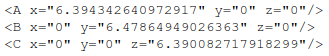


- 4) Select *OpenMM* for the format of input files and download the tarball with the converted system.

- 5) We will need some files to start our second equilibration. You can find them at *charmm-gui-XXXXXXX/openmm/*. Take your time to find and select:

 - *step3_charmm2omm.psf* containing the system topology.
 - *step3_charmm2omm.pdb* containing the system coordinates.
 - The restraint file (at *openmm/restraints/prot_pos.txt*) containing the atoms that will be restrained during equilibration.
 - The *toppar_drude* folder containing force field parameter files.
 - The *toppar.str* file pointing to the force field files that we will use in our simulation.
 - The *.rst* file from the **additive equilibration**. We will use that file to obtain **only** the box sizes.

Make a folder with these files and upload it to your Google Drive account. **IMPORTANT**: you will need to edit your *toppar.str* file! This file indicates where the .str files are located so OpenMM can read the force field parameters.


---
---
# **6) Equilibrating the polarizable simulation box**

Since we have new particles in the system and no velocities for them, we will reequilibrate the Drude system using a similar setup used for the additive system. However, it must be noticed that the use of the Drude force field **requires** the use of a timestep of 1 fs.

Below, we will set up the MD equilibration parameters, such as temperature, pressure and the desired simulation time. We will define the force constant used to restrain protein heavy-atoms in place and the frequency at which we want to save atomic coordinates in a trajectory file (.dcd).

In [16]:
#@title **Please, provide the necessary input files below:** 
PSF_filename = 'step3_charmm2omm.psf' #@param {type:"string"}
PDB_filename = 'step3_charmm2omm.pdb' #@param {type:"string"}
toppar_filename = 'toppar.str' #@param {type:"string"}
restraint_filename = 'prot_pos.txt' #@param {type:"string"}
RST_filename = '1ubq_equil.rst' #@param {type:"string"}

Google_Drive_Path = '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/' #@param {type:"string"}
workDir = Google_Drive_Path

top = os.path.join(workDir, str(PSF_filename))
toppar = os.path.join(workDir, str(toppar_filename))
res = os.path.join(workDir, str(restraint_filename))
pdb = os.path.join(workDir, str(PDB_filename))
rst = os.path.join(workDir, str(RST_filename))

pdb_check = os.path.exists(pdb)
res_check = os.path.exists(res)
top_check = os.path.exists(top)
toppar_check = os.path.exists(toppar)
rst_check = os.path.exists(rst)

if pdb_check == True and res_check == True and top_check == True and toppar_check == True and rst_check == True:
    print("Files loaded succesfully! ;-)")
else:
    print("ERROR! Check your input names and Google Drive path")

#@markdown ---

Files loaded succesfully! ;-)


In [17]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = '1ubq_drude_equil' #@param {type:"string"}
jobname = os.path.join(workDir,Jobname)

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds): 
Time = "5" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "1" #@param ["1"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure


#@markdown Position restraints force constant (in kJ/mol): 
Force_constant = 500 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---

In [ ]:
#@title **Running a Drude Equilibration MD simulation (NPT ensemble)**

#@markdown Now, let's equilibrate our system!
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch
import warnings
warnings.filterwarnings('ignore')

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def get_cubic_box(psf, rstfile):

	f = open(rstfile, 'r')

	box = {}

	while True:
		line = f.readline()
		if not line: break

		if line.split()[0] == "<A":
			size = line.split()[1].strip('x="')
			box['A'] = float(size)
		elif line.split()[0] == "<B":
			size = line.split()[2].strip('y="')
			box['B'] = float(size)
		elif line.split()[0] == "<C":
			size = line.split()[3].strip('z="').strip('"/>')
			box['C'] = float(size)
		else:
			pass

	boxX = box['A']*nanometer
	boxY = box['B']*nanometer
	boxZ = box['C']*nanometer

	psf.setBox(boxX, boxY, boxZ)

	return psf

def read_toppar(filename,path):
	extlist = ['rtf', 'prm', 'str']

	parFiles = ()
	for line in open(filename, 'r'):
		if '!' in line: line = line.split('!')[0]
		parfile = line.strip()
		if len(parfile) != 0:
			ext = parfile.lower().split('.')[-1]
			if not ext in extlist: continue
			parFiles += ( path + parfile, )

	params = CharmmParameterSet( *parFiles )
	return params, parFiles

def restraints(system, crd, fc_bb, restraint_file):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc_bb > 0:
		# positional restraints for protein
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')
		for line in open(restraint_file, 'r'):
			segments = line.strip().split()
			atom1 = int(segments[0])
			state = segments[1]
			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]
			if state == 'BB':
				fc_ppos = fc_bb
				posresPROT.addParticle(atom1, [fc_ppos, xpos, ypos, zpos])
			if state == 'SC':
				fc_ppos = fc_bb
				posresPROT.addParticle(atom1, [fc_ppos, xpos, ypos, zpos])
		system.addForce(posresPROT)

	return system
##############################################


#############################################
# Defining MD simulation parameters

top = os.path.join(workDir, str(PSF_filename))
toppar = os.path.join(workDir, str(toppar_filename))
pdb = os.path.join(workDir, str(PDB_filename))
restraint_file = os.path.join(workDir, str(restraint_filename))
rst = os.path.join(workDir, str(RST_filename))

coordinatefile = pdb
topologyfile = top

time_ps = float(Time)*1000 #convert to picosecond
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

charmm_params, toppar_files = read_toppar(toppar,workDir)

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tRestraint file = " + str(restraint_file))
print("\tTopology file = " + str(topologyfile))
print("\tForce Field files = " + str(toppar_files))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

print("\t- Reading topology and structure file...")
psf = CharmmPsfFile(topologyfile)
crd = PDBFile(coordinatefile)

print("\t- Setting box (using user's information)...")
psf = get_cubic_box(psf, rst)

print("\t- Creating system and setting parameters...")
system = psf.createSystem(charmm_params, nonbondedMethod=PME, nonbondedCutoff=1.2*nanometer, switchDistance=1.0*nanometer, ewaldErrorTolerance = 0.0001, constraints=HBonds)

nbforce = [system.getForce(i) for i in range(system.getNumForces()) if isinstance(system.getForce(i), NonbondedForce)][0]
nbforce.setNonbondedMethod(NonbondedForce.PME)
nbforce.setEwaldErrorTolerance(0.0001)
nbforce.setCutoffDistance(1.2*nanometer)
nbforce.setUseSwitchingFunction(True)
nbforce.setSwitchingDistance(1.0*nanometer)

# not every system has NBFIX terms, so check
cstnb = [system.getForce(i) for i in range(system.getNumForces()) if isinstance(system.getForce(i), CustomNonbondedForce)]
if cstnb:
	nbfix = cstnb[0]
	nbfix.setNonbondedMethod(CustomNonbondedForce.CutoffPeriodic)
	nbfix.setCutoffDistance(1.2*nanometer)
	nbfix.setUseSwitchingFunction(True)
	nbfix.setSwitchingDistance(1.0*nanometer)

print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
system = restraints(system, crd, restraint_fc, restraint_file)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator and thermostat...")
integrator = DrudeLangevinIntegrator(temperature, 5/picosecond, 1*kelvin, 20/picosecond, 0.001*picoseconds)
integrator.setMaxDrudeDistance(0.02) # Drude Hardwall

simulation = Simulation(psf.topology, system, integrator)
simulation.context.setPositions(crd.positions)
simulation.context.computeVirtualSites()

print('\t- Using platform:', simulation.context.getPlatform().getName())

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

if os.path.exists(rst_file):
    print("\n\n> Equilibration finished (" + rst_file + " present). Nothing to do here... <")
    exit
    sys.exit()

else:
	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (nsteps) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps...")
	simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
u = mda.Universe(top, dcd_file) 
system = u.select_atoms('all')
for ts in u.trajectory[(len(u.trajectory)-1):len(u.trajectory)]: 
	with mda.Writer(str(pdb_file), system.n_atoms) as W:
		W.write(system)

print("\n> Finished!\n")



> Simulation details:

	Job name = /content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/1ubq_drude_equil
	Coordinate file = /content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/step3_charmm2omm.pdb
	Restraint file = /content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/prot_pos.txt
	Topology file = /content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/step3_charmm2omm.psf
	Force Field files = ('/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/toppar_drude/toppar_drude_master_protein_2019h.str', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/toppar_drude/toppar_drude_d_aminoacids_2019g.str', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/toppar_drude/toppar_drude_carbohydrate_2019b.str', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/toppar_drude/toppar_drude_nucleic_acid_2017c.str', '/content/drive/MyDrive/MolecularDynamics_2023/OpenMM_Drude/drude/toppar_drude/toppar_

---
---
# **7) Running a Drude Production MD simulation**

Finally, we will proceed with the Production simulation itself using the equilibrated system coordinates as input structure. We will use the same .psf topology file and the same force field files. 

Note that we will use here a *.rst state file* , which contains atomic velocities and positions from the last frame of the equilibration simulation, guaranteeing that our production simulation begins from a thermodynamically equilibrated system.

The other important information here is the **Number_of_strides** and the **Stride_Time**. In this notebook, we simulate a defined number of *strides*, so the **simulation time = Number_of_strides*Stride_Time**. For example, we can simulate 100ns by setting *Number_of_strides=10* and *Stride_Time=10 ns*.

**Important: at the end of the Production simulation, we concatenate all strides to create a complete trajectory file which can be visualized and analyzed**

The idea behind this approach is to make use of the intermitent 12h/24h period that Google Colab allows us to use its GPUs. 

In [ ]:
#@markdown ---
#@markdown ### **Provide input file names below:** 

PSF_file = 'step3_charmm2omm.psf' #@param {type:"string"}
Equilibrated_PDB = '1ubq_drude_equil.pdb' #@param {type:"string"}
Toppar_file = 'toppar.str' #@param {type:"string"}
State_file = '1ubq_drude_equil.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = '1ubq_drude_prod' #@param {type:"string"}
jobname = os.path.join(workDir, Jobname)

#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds): 
Stride_Time = "5" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "2" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "1" #@param ["1"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log

#@markdown ---

In [ ]:
#@title **Run Production MD simulation (NPT ensemble) after equilibration**
#
#@markdown
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def get_cubic_box(psf, rstfile):

	f = open(rstfile, 'r')

	box = {}

	while True:
		line = f.readline()
		if not line: break

		if line.split()[0] == "<A":
			size = line.split()[1].strip('x="')
			box['A'] = float(size)
		elif line.split()[0] == "<B":
			size = line.split()[2].strip('y="')
			box['B'] = float(size)
		elif line.split()[0] == "<C":
			size = line.split()[3].strip('z="').strip('"/>')
			box['C'] = float(size)
		else:
			pass

	boxX = box['A']*nanometer
	boxY = box['B']*nanometer
	boxZ = box['C']*nanometer

	psf.setBox(boxX, boxY, boxZ)

	return psf

def read_toppar(filename,path):
	extlist = ['rtf', 'prm', 'str']

	parFiles = ()
	for line in open(filename, 'r'):
		if '!' in line: line = line.split('!')[0]
		parfile = line.strip()
		if len(parfile) != 0:
			ext = parfile.lower().split('.')[-1]
			if not ext in extlist: continue
			parFiles += ( path + parfile, )

	params = CharmmParameterSet( *parFiles )
	return params, parFiles
##############################################


#############################################
# Defining MD simulation parameters

topologyfile = os.path.join(workDir, PSF_file)
pdbfile = os.path.join(workDir, Equilibrated_PDB)
toppar = os.path.join(workDir,Toppar_file)
equil_rst_file = os.path.join(workDir,State_file)


stride_time_ps = float(stride_time_prod)*1000 #convert to picosecond
stride_time = float(stride_time_ps)*picosecond		# in ps
nstride = int(nstride)
dt = int(dt_prod)*femtosecond
simulation_time = stride_time*nstride

temperature = float(temperature_prod)*kelvin
pressure	= float(pressure_prod)*bar

savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

charmm_params, toppar_files = read_toppar(toppar,workDir)

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))
print("\tForce Field files = " + str(toppar_files))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tNumber of strides = " + str(nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################
print("\n> Setting the system:\n")
print("\t- Creating system and setting parameters...")
system = psf.createSystem(charmm_params, nonbondedMethod=PME, nonbondedCutoff=1.2*nanometer, switchDistance=1.0*nanometer, ewaldErrorTolerance = 0.0001, constraints=HBonds)

nbforce = [system.getForce(i) for i in range(system.getNumForces()) if isinstance(system.getForce(i), NonbondedForce)][0]
nbforce.setNonbondedMethod(NonbondedForce.PME)
nbforce.setEwaldErrorTolerance(0.0001)
nbforce.setCutoffDistance(1.2*nanometer)
nbforce.setUseSwitchingFunction(True)
nbforce.setSwitchingDistance(1.0*nanometer)

# not every system has NBFIX terms, so check
cstnb = [system.getForce(i) for i in range(system.getNumForces()) if isinstance(system.getForce(i), CustomNonbondedForce)]
if cstnb:
	nbfix = cstnb[0]
	nbfix.setNonbondedMethod(CustomNonbondedForce.CutoffPeriodic)
	nbfix.setCutoffDistance(1.2*nanometer)
	nbfix.setUseSwitchingFunction(True)
	nbfix.setSwitchingDistance(1.0*nanometer)

print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
system = restraints(system, crd, restraint_fc, restraint_file)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator and thermostat...")
integrator = DrudeLangevinIntegrator(temperature, 5/picosecond, 1*kelvin, 20/picosecond, 0.001*picoseconds)
integrator.setMaxDrudeDistance(0.02) # Drude Hardwall

simulation = Simulation(psf.topology, system, integrator)
simulation.context.setPositions(crd.positions)
simulation.context.computeVirtualSites()

print('\t- Using platform:', simulation.context.getPlatform().getName())

# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")
   
	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


In [ ]:
#@title **Concatenate and align the trajectory**
#@markdown **Important**: The **Google Drive Path**, **Jobname**, **Number of strides**, **stride time** and **trajectory saved frequency** should be the same you have been used to run your simulation in the previous steps. 

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

Google_Drive_Path = '/content/drive/MyDrive/' #@param {type:"string"}
workDir = Google_Drive_Path
Equilibrated_PDB = '1ubq_drude_equil.pdb' #@param {type:"string"}
Jobname = "1ubq_drude_prod" #@param {type: "string"}
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@param {type:"string"}
Number_of_strides = "2" #@param {type:"string"}
nstride = int(Number_of_strides)
stride_time = "5" #@param {type:"string"}
trajectory_saved_frequency = "10" #@param ["10", "100", "200", "500", "1000"]
traj_save_freq = trajectory_saved_frequency
Remove_waters = "yes" #@param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(stride_traj)


# traj_end = os.path.join(workDir, str(Jobname) + "_all.dcd")
nw_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_nw." + str(Output_format))
nw_pdb = os.path.join(workDir, str(Jobname) +  "_nw.pdb")
whole_pdb = os.path.join(workDir, str(Jobname) +  "_whole.pdb")
whole_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_whole." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]
ref = [template % int(1)]

u1 = mda.Universe(pdb, flist)
u2 = mda.Universe(pdb, ref)

u2.trajectory[0] # set u2 to first frame

# print(rms.rmsd(u1.select_atoms('name CA').positions, u2.select_atoms('name CA').positions, superposition=False))

align.AlignTraj(u1, u2, select='name CA', in_memory=True).run()

nw = u1.select_atoms("not (resname SWM4)")
if Remove_waters == "yes":
  with mda.Writer(nw_dcd, nw.n_atoms) as W:
    for ts in u1.trajectory[::int(Skip)]:
        W.write(nw, )
  not_waters = u2.select_atoms("not (resname SWM4)")
  not_waters.write(nw_pdb)
  traj_dcd_check = os.path.exists(nw_dcd)
  traj = nw_dcd
  pdb_ref = nw_pdb
else:
  with mda.Writer(whole_dcd, u1.select_atoms("all").n_atoms) as W:
    for ts in u1.trajectory[::int(Skip)]:
        W.write(u1.select_atoms("all"))
  whole = u2.select_atoms("all")
  whole.write(whole_pdb)
  traj_dcd_check = os.path.exists(whole_dcd)
  traj = whole_dcd
  pdb_ref = whole_pdb

traj_load = pt.load(traj, pdb_ref)
print(traj_load)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

In [ ]:
#@title **Load, view and check the trajectory**
#@markdown This will take a few minutes. Another coffee would be great. :-)

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"
        
class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))
            
    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe(pdb_ref, traj) 

# Write out frames for animation
protein = u.select_atoms('not (resname SWM4)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]: 
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

---
---
# **8) Analysis**

Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of MD trajectories vary a lot and we do not intend to cover them all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations. 

Below, you can find a few examples of code snippets that can help you to shed some light on your simulation behavior.

In [ ]:
#@title **Compute RMSD of protein's CA atoms**
#@markdown **Provide output file names below:** 
Output_name = 'rmsd_ca' #@param {type:"string"}


rmsd = pt.rmsd(traj_load, ref = 0, mask = "@CA")

time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, rmsd, alpha=0.6, color = 'blue', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Plot RMSD as a ditribution**

#@markdown **Provide output file names below:** 
Output_name = 'rmsd_dist' #@param {type:"string"}

ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Compute radius of gyration of protein's CA atoms**

#@markdown **Provide output file names below:** 
Output_name = 'radius_gyration' #@param {type:"string"}

radgyr = pt.radgyr(traj_load, mask = "@CA")
time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
plt.plot(time_array, radgyr, alpha=0.6, color = 'green', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(radgyr)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Plot radius of gyration as a ditribution**

#@markdown **Provide output file names below:** 
Output_name = 'radius_gyration_dist' #@param {type:"string"}

ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Compute RMSF of protein's CA atoms**

#@markdown **Provide output file names below:** 
Output_name = 'rmsf_ca' #@param {type:"string"}


rmsf = pt.rmsf(traj_load, "@CA")
bfactor = pt.bfactors(traj_load, byres=True)

# Plotting:
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0)

plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **2D RMSD**

#@markdown **Provide output file names below:** 
Output_name = '2D_rmsd' #@param {type:"string"}

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

mat1 = pt.pairwise_rmsd(traj_load, mask="@CA", frame_indices=range(int(number_frames_analysis)))


ax = plt.imshow(mat1, cmap = 'PRGn', origin='lower', interpolation = 'bicubic')
plt.title('2D RMSD')
plt.xlabel('Time (ns)', fontsize = 14, fontweight = 'bold')
plt.ylabel('Time (ns)', fontsize = 14, fontweight = 'bold')
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
plt.xticks(a, b.round(decimals=3), fontsize = 12)
plt.yticks(a, b.round(decimals=3), fontsize = 12)
# plt.xlim(0, a[-1])
# plt.ylim(0, a[-1])

cbar1 = plt.colorbar()
cbar1.set_label("RMSD ($\AA$)", fontsize = 14, fontweight = 'bold')


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat1)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Calculate eigvenctors of Principle Component Analysis (PCA)**
data = pt.pca(traj_load, fit=True, ref=0, mask='@CA', n_vecs=2)
#print('projection values of each frame to first mode = {} \n'.format(data[0][0]))
#print('projection values of each frame to second mode = {} \n'.format(data[0][1]))
#print('eigvenvalues of first two modes', data[1][0])
#print("")
#print('eigvenvectors of first two modes: \n', data[1][1])

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
a2 = a.tolist()
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

#@markdown **Provide output file names below:** 
Output_name = 'PCA' #@param {type:"string"}

Output_PC1 = 'PC1' #@param {type:"string"}
Output_PC2 = 'PC2' #@param {type:"string"}

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
projection_data = data[0]
plt.title(r'PCA of C-$\alpha$')
PC1 = data[0][0] 
PC2 = data[0][1]

a = plt.scatter(PC1,PC2, c=range(int(number_frames_analysis)), cmap='Greens', marker='o',s=8, alpha=1)
plt.clim(0, last_frame)

plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# N = len(number_frames)
# x2 = np.arange(N)

cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Time(ns)', fontsize = 14, fontweight = 'bold')
cbar1.set_ticks(a2)
cbar1.set_ticklabels(b.round(decimals=3))

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

pc1=pd.DataFrame(PC1)
pc1.to_csv(os.path.join(workDir, Output_PC1 + ".csv"))
pc2=pd.DataFrame(PC2)
pc2.to_csv(os.path.join(workDir, Output_PC2 + ".csv"))

In [ ]:
#@title **Plot Principal Component 1 (PC1) and Principal Component 2 (PC2) as a ditribution**
Output_name = 'PCA_dist' #@param {type:"string"}


fig = plt.figure(figsize=(9,5))

plt.subplot(1, 2, 1)
ax = sb.kdeplot(PC1, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.subplot(1, 2, 2)
ax2 = sb.kdeplot(PC2, color="purple", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
#@title **Pearson's Cross Correlation (CC)**

#@markdown **Provide output file names below:** 
Output_name = 'cross_correlation' #@param {type:"string"}


traj_align = pt.align(traj_load, mask='@CA', ref=0)

mat_cc = matrix.correl(traj_align, '@CA')

ax = plt.imshow(mat_cc, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')

plt.xlabel('Residues', fontsize = 14, fontweight = 'bold')
plt.ylabel('Residues', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat_cc)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))